# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [81]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  72.73 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 50000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 50000
Taking FFT of the images:
Batch 1/10  13.76 sec.
Batch 2/10  13.65 sec.
Batch 3/10  13.66 sec.
Batch 4/10  15.10 sec.
Batch 5/10  13.67 sec.
Batch 6/10  13.66 sec.
Batch 7/10  13.66 sec.
Batch 8/10  15.21 sec.
Batch 9/10  13.81 sec.
Batch 10/10  14.38 sec.
FFT done. Time:  173.28 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (50000, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  19.36 sec.


### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [153]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [154]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [202]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [240]:
N_epochs = 5
batch_size = 64
step_size = 1000000 # 1e-3

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [241]:
v_rec, loss_rec, grad_rec = sgd(grad_func, loss_func, N, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)

Epoch 1/5 

100%|██████████| 781/781 [00:47<00:00, 16.61it/s, grad=1.929e-04, loss=5912.30]


  |Grad| = 1.624e-04
  |Loss| = 5934.615
Epoch 2/5 

100%|██████████| 781/781 [00:47<00:00, 16.43it/s, grad=1.443e-04, loss=5889.89]


  |Grad| = 1.631e-04
  |Loss| = 5934.272
Epoch 3/5 

100%|██████████| 781/781 [00:47<00:00, 16.28it/s, grad=1.567e-04, loss=5947.20]


  |Grad| = 1.626e-04
  |Loss| = 5934.243
Epoch 4/5 

100%|██████████| 781/781 [00:47<00:00, 16.46it/s, grad=1.515e-04, loss=5883.19]


  |Grad| = 1.630e-04
  |Loss| = 5934.282
Epoch 5/5 

100%|██████████| 781/781 [00:46<00:00, 16.65it/s, grad=1.470e-04, loss=5929.03]


  |Grad| = 1.634e-04
  |Loss| = 5934.245


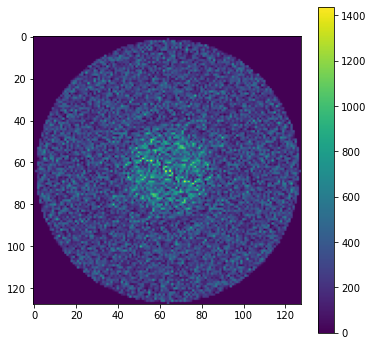

In [242]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

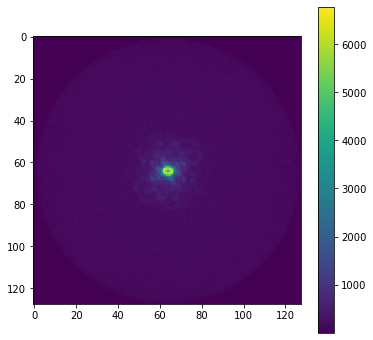

In [243]:
mip_z(np.fft.fftshift(np.abs(v_rec))); plt.colorbar()

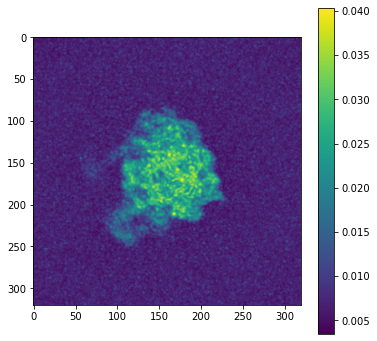

In [244]:
v_rec_l, x_grid_l = rescale_larger_grid(v_rec, x_grid, nx0)
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))
mip_z(vr_sgd)
plt.colorbar()

In [245]:
with mrcfile.new(f"{out_dir}/vr_rec_sgd5ep.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))
    
    